<a href="https://colab.research.google.com/github/mehkzhra/Mask-Detection/blob/main/Webcam_Mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install kaggle
!pip install kaggle --quiet

# Make directory for kaggle config
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Download the dataset using Kaggle API
!kaggle datasets download -d andrewmvd/face-mask-detection


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
 86% 341M/398M [00:00<00:00, 541MB/s]
100% 398M/398M [00:00<00:00, 571MB/s]


In [ ]:
import zipfile

zip_path = "face-mask-detection.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")


In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET

annotations_dir = "dataset/annotations"
images_dir = "dataset/images"

# Output dirs
with_mask_dir = "dataset/with_mask"
without_mask_dir = "dataset/without_mask"

os.makedirs(with_mask_dir, exist_ok=True)
os.makedirs(without_mask_dir, exist_ok=True)

for xml_file in os.listdir(annotations_dir):
    if not xml_file.endswith(".xml"):
        continue

    xml_path = os.path.join(annotations_dir, xml_file)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Every XML has <filename>
    img_name = root.find("filename").text
    img_path = os.path.join(images_dir, img_name)

    # Find annotation class label
    labels = [obj.find("name").text for obj in root.findall("object")]

    # Most images have 1 person → use the first label
    label = labels[0]

    # Map label to mask / no-mask
    if label in ["with_mask"]:
        dst_folder = with_mask_dir
    elif label in ["without_mask"]:
        dst_folder = without_mask_dir
    else:
        # Skip mask_weared_incorrect (optional)
        continue

    shutil.copy(img_path, dst_folder)

print("Images successfully separated into with_mask/ and without_mask/")


Images successfully separated into with_mask/ and without_mask/


In [ ]:
import shutil

# Remove folders that confuse ImageFolder
shutil.rmtree("dataset/annotations", ignore_errors=True)
shutil.rmtree("dataset/images", ignore_errors=True)

print("Cleanup completed!")


Cleanup completed!


In [ ]:
!ls dataset


with_mask  without_mask


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder("dataset", transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
print("Classes:", class_names)
print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))


Classes: ['with_mask', 'without_mask']
Train images: 653
Test images: 164


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(1280, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), "mask_detector.pth")
print("Training completed & model saved!")


Device: cpu


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 39.1MB/s]


Epoch 1/5 - Loss: 0.5626
Epoch 2/5 - Loss: 0.1889
Epoch 3/5 - Loss: 0.0965
Epoch 4/5 - Loss: 0.0583
Epoch 5/5 - Loss: 0.0285
Training completed & model saved!


In [ ]:
!pip install opencv-python


Photo saved at: photo.jpg


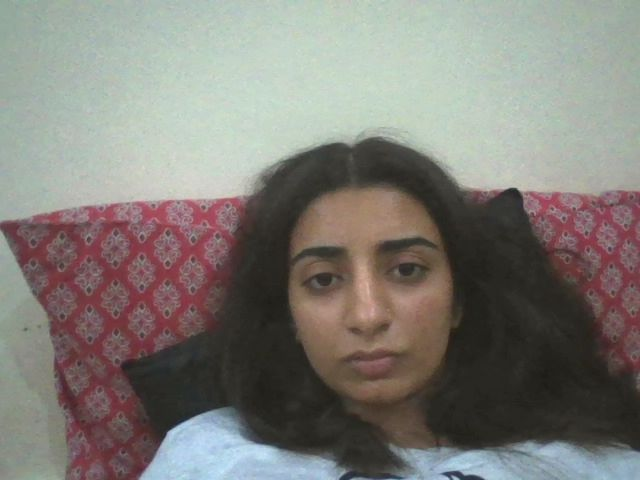

In [ ]:
from google.colab import output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import IPython.display as display

def take_photo(filename='photo.jpg', quality=0.8):
    js = """
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);

      video.srcObject = stream;
      await video.play();

      // Resize video feed in colab
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        const btn = document.createElement('button');
        btn.textContent = '📸 Capture Photo';
        btn.style.fontSize = '20px';
        btn.style.marginTop = '10px';
        btn.onclick = resolve;
        div.appendChild(btn);
      });

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      stream.getVideoTracks()[0].stop();
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    """
    js_output = eval_js(js + f"takePhoto({quality});")
    img_bytes = b64decode(js_output.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(img_bytes)
    return filename

# Capture photo
photo_path = take_photo()
print("Photo saved at:", photo_path)

display.Image(photo_path)


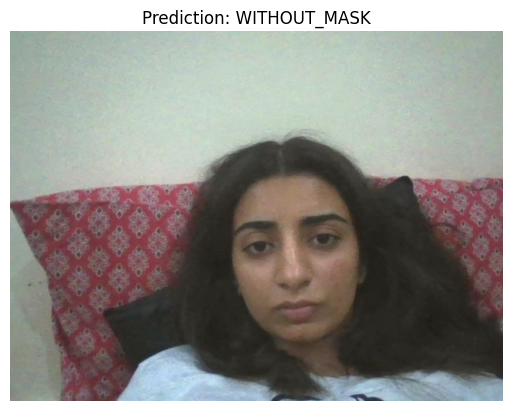


Final Prediction: WITHOUT_MASK


In [ ]:
# --- STEP B: Predict the image captured from webcam ---

from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

def predict_image(photo_path):
    model.eval()

    img = Image.open(photo_path).convert("RGB")

    # Same transforms as training
    test_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    img_t = test_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        _, pred = torch.max(output, 1)

    predicted_label = class_names[pred.item()]
    return predicted_label, img

# -----------------------
# USE THIS AFTER WEBCAM
# -----------------------

# Ensure photo_path points to the correctly saved file
photo_path = "photo.jpg"
label, img_shown = predict_image(photo_path)

plt.imshow(img_shown)
plt.title(f"Prediction: {label.upper()}")
plt.axis("off")
plt.show()

print("\nFinal Prediction:", label.upper())